notebook1
## PART 1. Document retrieval

Prepare the environment and import all library we need

In [19]:
# built-in libs
import json
import pickle
# Python Pickle is used to serialize and deserialize a python object structure
import re
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Set, Tuple, Union

# 3rd party libs
import hanlp
import opencc
from opencc import OpenCC
import pandas as pd
import wikipedia
# Wikipedia is a Python library that makes it easy to access and parse data from Wikipedia.
from hanlp.components.pipeline import Pipeline
from pandarallel import pandarallel
from tqdm import tqdm
import psutil
tqdm.pandas() # for progress_apply
# our own libs
from utils import load_json
cpus = psutil.cpu_count(logical=False)
print("total cpu numbers:", cpus)
pandarallel.initialize(progress_bar=True, verbose=0, nb_workers=cpus)
# nb_worker change to cpus
wikipedia.set_lang("zh")
# Set the Wikipedia language.

total cpu numbers: 14


Preload the data.

In [20]:
# (change)
TRAIN_DATA = load_json("./data/public_train.jsonl")
TEST_DATA = load_json("./data/test.jsonl")
CONVERTER_T2S = OpenCC('t2s')
CONVERTER_S2T = OpenCC('s2t')

Data class for type hinting

In [21]:
@dataclass
class Claim:
    data: str

@dataclass
class AnnotationID:
    id: int

@dataclass
class EvidenceID:
    id: int

@dataclass
class PageTitle:
    title: str

@dataclass
class SentenceID:
    id: int

@dataclass
class Evidence:
    data: List[List[Tuple[AnnotationID, EvidenceID, PageTitle, SentenceID]]]

### Function Area

In [22]:
# convert traditional to simplified Chinese 
def do_st_corrections(text: str) -> str:
    simplified = CONVERTER_T2S.convert(text)

    return CONVERTER_S2T.convert(simplified)
# convert claim to Constituency Parsing tree
def get_nps_hanlp(
    predictor: Pipeline,
    d: Dict[str, Union[int, Claim, Evidence]],
) -> List[str]:
    claim = d["claim"]
    tree = predictor(claim)["con"]
    nps = [
        do_st_corrections("".join(subtree.leaves()))
        for subtree in tree.subtrees(lambda t: t.label() == "NP")
    ]
    return nps
# save file in json
def save_doc(
    data: List[Dict[str, Union[int, Claim, Evidence]]],
    predictions: pd.Series,
    mode: str = "train",
    num_pred_doc: int = 5,
) -> None:
    with open(
        f"data/{mode}_doc{num_pred_doc}.jsonl",
        "w",
        encoding="utf8",
    ) as f:
        for i, d in enumerate(data):
            d["predicted_pages"] = list(predictions.iloc[i])
            f.write(json.dumps(d, ensure_ascii=False) + "\n")
# append tokens list in claim
def get_pred_pages(series_data: pd.Series) -> Set[Dict[int, str]]:
# import package and define fuction
    import wikipedia
    import re
    import pandas as pd
    from opencc import OpenCC
    wikipedia.set_lang("zh")
    CONVERTER_T2S = OpenCC('t2s')
    CONVERTER_S2T = OpenCC('s2t')
    def do_st_corrections(text: str) -> str:
        simplified = CONVERTER_T2S.convert(text)
        return CONVERTER_S2T.convert(simplified)
    
    results = []
    tmp_muji = []
    # wiki_page: its index showned in claim
    mapping = {}
    claim = series_data["claim"]
    nps = series_data["hanlp_results"]
    first_wiki_term = []

    for i, np in enumerate(nps):
        # Simplified Traditional Chinese Correction
        wiki_search_results = [
            do_st_corrections(w) for w in wikipedia.search(np)
        ]

        # Remove the wiki page's description in brackets
        wiki_set = [re.sub(r"\s\(\S+\)", "", w) for w in wiki_search_results]
        wiki_df = pd.DataFrame({
            "wiki_set": wiki_set,
            "wiki_results": wiki_search_results
        })

        # Elements in wiki_set --> index
        # Extracting only the first element is one way to avoid extracting
        # too many of the similar wiki pages
        grouped_df = wiki_df.groupby("wiki_set", sort=False).first()
        candidates = grouped_df["wiki_results"].tolist()
        # muji refers to wiki_set
        muji = grouped_df.index.tolist()

        for prefix, term in zip(muji, candidates):
            if prefix not in tmp_muji:
                matched = False

                # Take at least one term from the first noun phrase
                if i == 0:
                    first_wiki_term.append(term)

                # Walrus operator :=
                # https://docs.python.org/3/whatsnew/3.8.html#assignment-expressions
                # Through these filters, we are trying to figure out if the term
                # is within the claim
                if (((new_term := term) in claim) or
                    ((new_term := term.replace("·", "")) in claim) or
                    ((new_term := term.split(" ")[0]) in claim) or
                    ((new_term := term.replace("-", " ")) in claim)):
                    matched = True

                elif "·" in term:
                    splitted = term.split("·")
                    for split in splitted:
                        if (new_term := split) in claim:
                            matched = True
                            break

                if matched:
                    # post-processing
                    term = term.replace(" ", "_")
                    term = term.replace("-", "")
                    results.append(term)
                    mapping[term] = claim.find(new_term)
                    tmp_muji.append(new_term)

    # 5 is a hyperparameter (change)
    if len(results) > 5:
        assert -1 not in mapping.values()
        results = sorted(mapping, key=mapping.get)[:5]
    elif len(results) < 1:
        results = first_wiki_term

    return set(results)
# calculate (hits/predicted_pages)/data_amount and hit is 1 when evidence[2] in predicted_pages
def calculate_precision(
    data: List[Dict[str, Union[int, Claim, Evidence]]],
    predictions: pd.Series,
) -> None:
    precision = 0
    count = 0

    for i, d in enumerate(data):
        if d["label"] == "NOT ENOUGH INFO":
            continue

        # Extract all ground truth of titles of the wikipedia pages
        # evidence[2] refers to the title of the wikipedia page
        gt_pages = set([
            evidence[2]
            for evidence_set in d["evidence"]
            for evidence in evidence_set
        ])

        predicted_pages = predictions.iloc[i]
        hits = predicted_pages.intersection(gt_pages)
        if len(predicted_pages) != 0:
            precision += len(hits) / len(predicted_pages)

        count += 1

    # Macro precision
    print(f"Precision: {precision / count}")

# # calculate hits/evidence_amount and hit is 1 when evidence[2] in predicted_pages
def calculate_recall(
    data: List[Dict[str, Union[int, Claim, Evidence]]],
    predictions: pd.Series,
) -> None:
    recall = 0
    count = 0

    for i, d in enumerate(data):
        if d["label"] == "NOT ENOUGH INFO":
            continue

        gt_pages = set([
            evidence[2]
            for evidence_set in d["evidence"]
            for evidence in evidence_set
        ])
        predicted_pages = predictions.iloc[i]
        hits = predicted_pages.intersection(gt_pages)
        recall += len(hits) / len(gt_pages)
        count += 1

    print(f"Recall: {recall / count}")

### Step 1. Get noun phrases from hanlp consituency parsing tree

Setup [HanLP](https://github.com/hankcs/HanLP) predictor (1 min)             
  HanLP將中文分詞、詞性標註和命名實體識別3個任務統稱為詞法分析  
  1. FINE_ELECTRA_SMALL_ZH
  - Tokenization is a way of separating a sentence into smaller units called tokens. In lexical analysis, tokens usually refer to words.  
  - FINE_ELECTRA_SMALL_ZH is pre-trained tokenizers and Electra (Clark et al. 2020) small model trained on fine-grained CWS corpora.  
  - Its performance is P: 98.14% R: 98.07% F1: 98.11% which is much higher than that of MTL model  
  - HanLP Documentation [Tok](https://hanlp.hankcs.com/docs/api/hanlp/pretrained/tok.html)  
  ---
  2. CTB9_CON_ELECTRA_SMALL
  - Constituency Parsing is the process of analyzing the sentences by breaking down it into sub-phrases also known as constituents.
  - To parse a tokenized sentence into constituency tree, first load a parser:
  - Electra (Clark et al. 2020) small tree CRF model (Zhang et al. 2020) trained on CTB9 with major categories. Its performance is UCM=39.06% LCM=34.99% UP=90.05% UR=90.01% UF=90.03% LP=87.02% LR=86.98% LF=87.00%.
  - HanLP Documentation[constituency](https://hanlp.hankcs.com/docs/api/hanlp/pretrained/constituency.html)
  

                  Sentence  
                     |  
       +-------------+------------+  
       |                          |  
  Noun Phrase                Verb Phrase  
       |                          |  
     John                 +-------+--------+  
                          |                |  
                        Verb          Noun Phrase  
                          |                |  
                        sees              Bill  

TP(True Positive), TN(True Negative), FP(False Positive), FN(False Negative)  
Recall(召回率) = TP/(TP+FN)  
Precision(準確率) = TP/(TP+FP)  
F1-score = 2 * Precision * Recall / (Precision + Recall)  
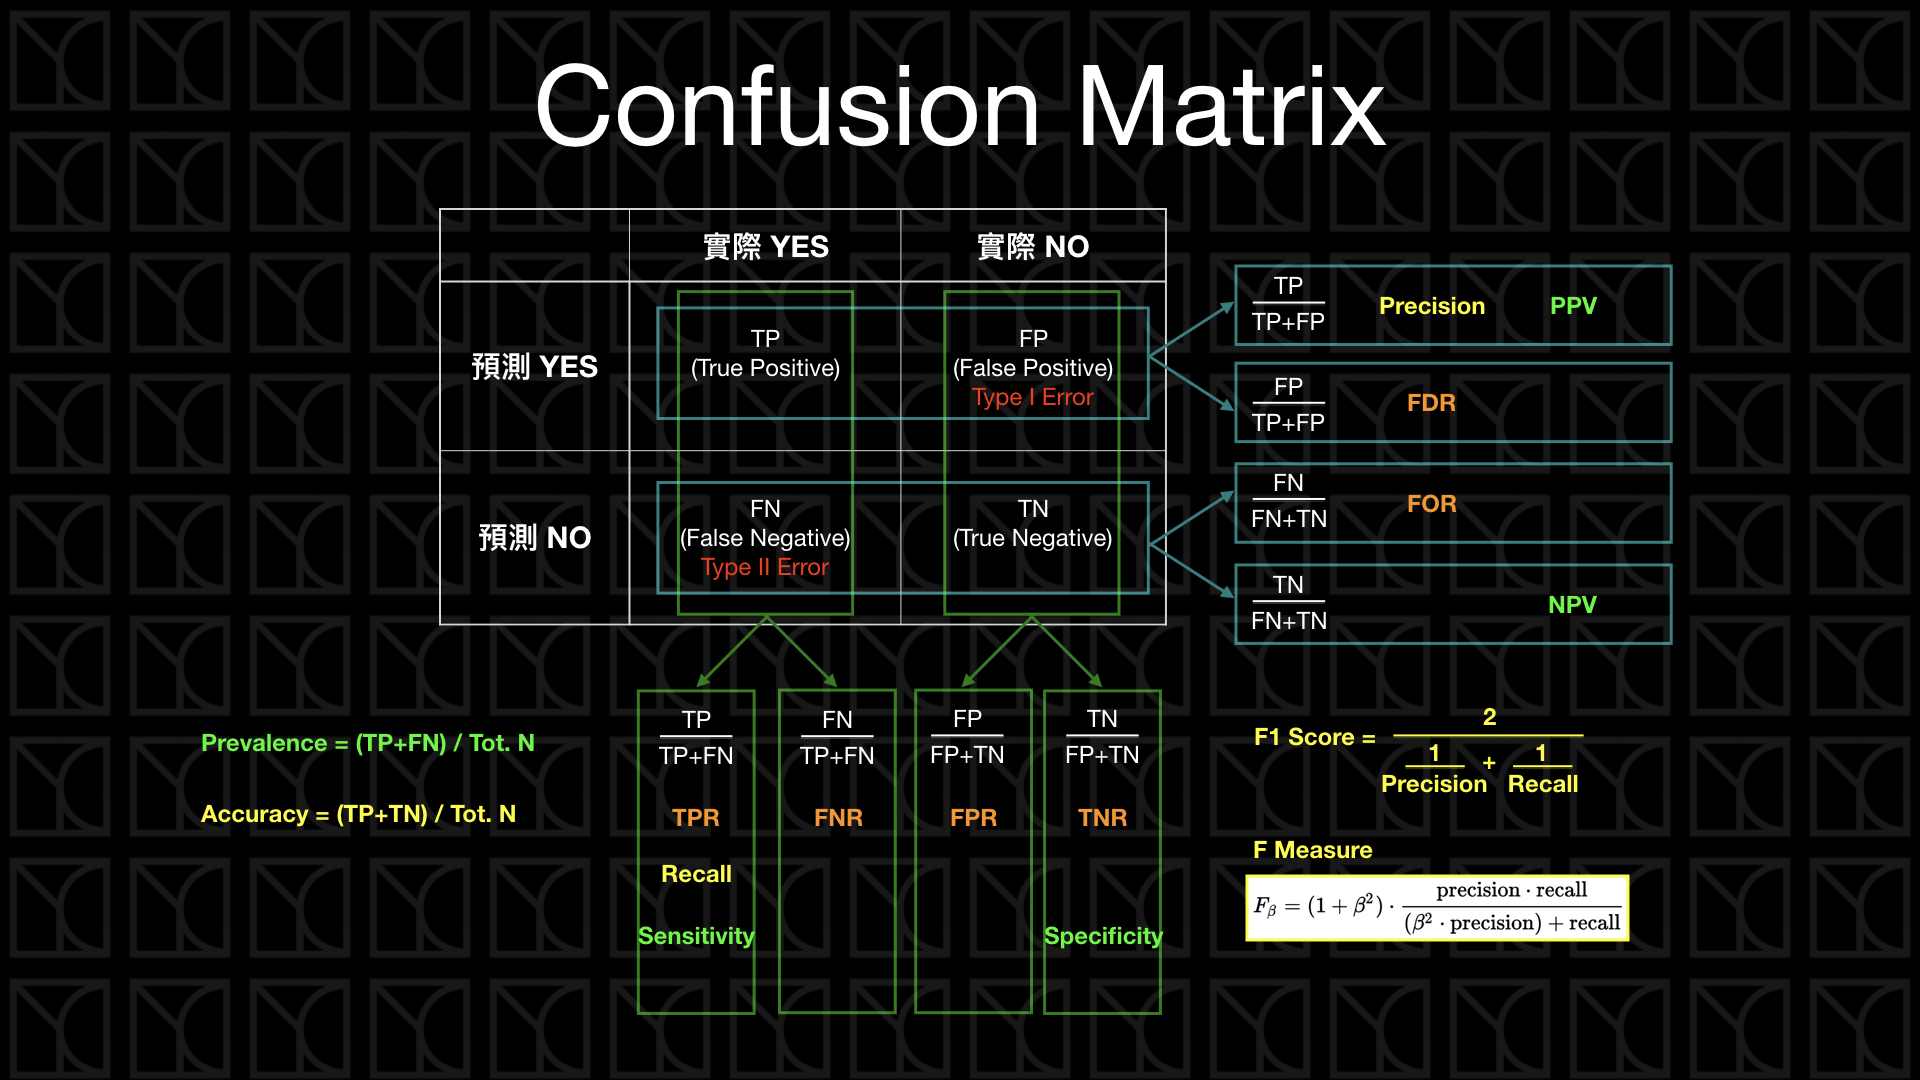


In [23]:
# run 2 min 16 second if no file
# load tokenizers and Constituency Parsing model
predictor = (hanlp.pipeline().append(
    hanlp.load("FINE_ELECTRA_SMALL_ZH"),
    output_key="tok",
).append(
    hanlp.load("CTB9_CON_ELECTRA_SMALL"),
    output_key="con",
    input_key="tok",
))
# convert TRAIN_DATA(public_train.jsonl) to Constituency Parsing Tree and save as in hanlp_con_results.pkl
hanlp_file = f"data/hanlp_con_results.pkl"
if Path(hanlp_file).exists():
    with open(hanlp_file, "rb") as f:
        hanlp_results = pickle.load(f)
        #print("type:", type(hanlp_results), " length:", len(hanlp_results), "\n", hanlp_results[0])
else:
    hanlp_results = [get_nps_hanlp(predictor, d) for d in TRAIN_DATA]
    #print("type:", type(hanlp_results), " length:", len(hanlp_results), "\n", hanlp_results[0])
    with open(hanlp_file, "wb") as f:
        pickle.dump(hanlp_results, f)

In [24]:
# cpus=14 run 48min 58second if no file and easy fail
doc_path = f"data/train_doc5.jsonl"
if Path(doc_path).exists():
    with open(doc_path, "r", encoding="utf8") as f:
        predicted_results = pd.Series([
            set(json.loads(line)["predicted_pages"])
            for line in f
        ])
        print(type(predicted_results), "\n", predicted_results[1])
else:
    train_df = pd.DataFrame(TRAIN_DATA)
    #print(train_df.head(1))
    train_df.loc[:, "hanlp_results"] = hanlp_results
    #print(train_df.head(1))
    predicted_results = train_df.parallel_apply(get_pred_pages, axis=1)
    # parallel_apply改成progress_apply 因為會namerror
    print(type(predicted_results), "\n", predicted_results[1])
    save_doc(TRAIN_DATA, predicted_results, mode="train")

<class 'pandas.core.series.Series'> 
 {'南太平洋', '太平洋', '北冰洋', '信天翁科', '牠'}


### Step 2. Calculate our results

In [25]:
calculate_precision(TRAIN_DATA, predicted_results)
calculate_recall(TRAIN_DATA, predicted_results)

Precision: 0.24042932020967145
Recall: 0.8110580962669547


### Step 3. Repeat the same process on test set
Create parsing tree

In [26]:
# run 42 second if no file
hanlp_test_file = "data/hanlp_con_test_results.pkl"
if Path(hanlp_test_file).exists():
    with open(hanlp_test_file, "rb") as f:
        hanlp_test_results = pickle.load(f)
        #print("type:", type(hanlp_test_results), " length:", len(hanlp_test_results), "\n", hanlp_test_results[0])
else:
    hanlp_test_results = [get_nps_hanlp(predictor, d) for d in TEST_DATA]
    #print("type:", type(hanlp_test_results), " length:", len(hanlp_test_results), "\n", hanlp_test_results[0])
    with open(hanlp_test_file, "wb") as f:
        pickle.dump(hanlp_test_results, f)

In [27]:
# cpus = 14 run 11 min 56 second if no file and easy fail
test_doc_path = "data/test_doc5.jsonl"
if Path(test_doc_path).exists():
    with open(test_doc_path, "r", encoding="utf8") as f:
        test_results = pd.Series(
            [set(json.loads(line)["predicted_pages"]) for line in f])
        #print(type(test_results), "\n", test_results[1])
else:
    test_df = pd.DataFrame(TEST_DATA)
    test_df.loc[:, "hanlp_results"] = hanlp_test_results
    test_results = test_df.parallel_apply(get_pred_pages, axis=1)
    #print(type(test_results), "\n", test_results[1])
    save_doc(TEST_DATA, test_results, mode="test")

notebook2
## PART 2. Sentence retrieval

Import some libs

In [28]:
# built-in libs
from pathlib import Path
from typing import Dict, List, Set, Tuple, Union

# third-party libs
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_scheduler,
)
import psutil
from dataset import BERTDataset, Dataset

# local libs
from utils import (
    generate_evidence_to_wiki_pages_mapping,
    jsonl_dir_to_df,
    load_json,
    load_model,
    save_checkpoint,
    set_lr_scheduler,
)
cpus = psutil.cpu_count(logical=False)
print("total cpu numbers:", cpus)
pandarallel.initialize(progress_bar=True, verbose=0, nb_workers=cpus)
# nb_worker change to cpus

total cpu numbers: 14


function definition

In [29]:
# Calculate precision for sentence retrieval
def evidence_macro_precision(
    instance: Dict,
    top_rows: pd.DataFrame,
) -> Tuple[float, float]:
    """Calculate precision for sentence retrieval
    This function is modified from fever-scorer.
    https://github.com/sheffieldnlp/fever-scorer/blob/master/src/fever/scorer.py

    Args:
        instance (dict): a row of the dev set (dev.jsonl) of test set (test.jsonl)
        top_rows (pd.DataFrame): our predictions with the top probabilities

        IMPORTANT!!!
        instance (dict) should have the key of `evidence`.
        top_rows (pd.DataFrame) should have a column `predicted_evidence`.

    Returns:
        Tuple[float, float]:
        [1]: relevant and retrieved (numerator of precision)
        [2]: retrieved (denominator of precision)
    """
    this_precision = 0.0
    this_precision_hits = 0.0

    # Return 0, 0 if label is not enough info since not enough info does not
    # contain any evidence.
    if instance["label"].upper() != "NOT ENOUGH INFO":
        # e[2] is the page title, e[3] is the sentence index
        all_evi = [[e[2], e[3]]
                   for eg in instance["evidence"]
                   for e in eg
                   if e[3] is not None]
        claim = instance["claim"]
        predicted_evidence = top_rows[top_rows["claim"] ==
                                      claim]["predicted_evidence"].tolist()

        for prediction in predicted_evidence:
            if prediction in all_evi:
                this_precision += 1.0
            this_precision_hits += 1.0

        return (this_precision /
                this_precision_hits) if this_precision_hits > 0 else 1.0, 1.0

    return 0.0, 0.0
# Calculate recall for sentence retrieval
def evidence_macro_recall(
    instance: Dict,
    top_rows: pd.DataFrame,
) -> Tuple[float, float]:
    """Calculate recall for sentence retrieval
    This function is modified from fever-scorer.
    https://github.com/sheffieldnlp/fever-scorer/blob/master/src/fever/scorer.py

    Args:
        instance (dict): a row of the dev set (dev.jsonl) of test set (test.jsonl)
        top_rows (pd.DataFrame): our predictions with the top probabilities

        IMPORTANT!!!
        instance (dict) should have the key of `evidence`.
        top_rows (pd.DataFrame) should have a column `predicted_evidence`.

    Returns:
        Tuple[float, float]:
        [1]: relevant and retrieved (numerator of recall)
        [2]: relevant (denominator of recall)
    """
    # We only want to score F1/Precision/Recall of recalled evidence for NEI claims
    if instance["label"].upper() != "NOT ENOUGH INFO":
        # If there's no evidence to predict, return 1
        if len(instance["evidence"]) == 0 or all(
            [len(eg) == 0 for eg in instance]):
            return 1.0, 1.0

        claim = instance["claim"]

        predicted_evidence = top_rows[top_rows["claim"] ==
                                      claim]["predicted_evidence"].tolist()

        for evidence_group in instance["evidence"]:
            evidence = [[e[2], e[3]] for e in evidence_group]
            if all([item in predicted_evidence for item in evidence]):
                # We only want to score complete groups of evidence. Incomplete
                # groups are worthless.
                return 1.0, 1.0
        return 0.0, 1.0
    return 0.0, 0.0
# Calculate the scores of sentence retrieval
def evaluate_retrieval(
    probs: np.ndarray,
    df_evidences: pd.DataFrame,
    ground_truths: pd.DataFrame,
    top_n: int = 5,
    cal_scores: bool = True,
    save_name: str = None,
) -> Dict[str, float]:
    """Calculate the scores of sentence retrieval

    Args:
        probs (np.ndarray): probabilities of the candidate retrieved sentences
        df_evidences (pd.DataFrame): the candiate evidence sentences paired with claims
        ground_truths (pd.DataFrame): the loaded data of dev.jsonl or test.jsonl
        top_n (int, optional): the number of the retrieved sentences. Defaults to 2.

    Returns:
        Dict[str, float]: F1 score, precision, and recall
    """
    df_evidences["prob"] = probs
    top_rows = (
        df_evidences.groupby("claim").apply(
        lambda x: x.nlargest(top_n, "prob"))
        .reset_index(drop=True)
    )

    if cal_scores:
        macro_precision = 0
        macro_precision_hits = 0
        macro_recall = 0
        macro_recall_hits = 0

        for i, instance in enumerate(ground_truths):
            macro_prec = evidence_macro_precision(instance, top_rows)
            macro_precision += macro_prec[0]
            macro_precision_hits += macro_prec[1]

            macro_rec = evidence_macro_recall(instance, top_rows)
            macro_recall += macro_rec[0]
            macro_recall_hits += macro_rec[1]

        pr = (macro_precision /
              macro_precision_hits) if macro_precision_hits > 0 else 1.0
        rec = (macro_recall /
               macro_recall_hits) if macro_recall_hits > 0 else 0.0
        f1 = 2.0 * pr * rec / (pr + rec)

    if save_name is not None:
        # write doc7_sent5 file
        with open(f"data/{save_name}", "w") as f:
            for instance in ground_truths:
                claim = instance["claim"]
                predicted_evidence = top_rows[
                    top_rows["claim"] == claim]["predicted_evidence"].tolist()
                instance["predicted_evidence"] = predicted_evidence
                f.write(json.dumps(instance, ensure_ascii=False) + "\n")

    if cal_scores:
        return {"F1 score": f1, "Precision": pr, "Recall": rec}   
# Inference script to get probabilites for the candidate evidence sentences
def get_predicted_probs(
    model: nn.Module,
    dataloader: Dataset,
    device: torch.device,
) -> np.ndarray:
    """Inference script to get probabilites for the candidate evidence sentences

    Args:
        model: the one from HuggingFace Transformers
        dataloader: devset or testset in torch dataloader

    Returns:
        np.ndarray: probabilites of the candidate evidence sentences
    """
    model.eval()
    probs = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            probs.extend(torch.softmax(logits, dim=1)[:, 1].tolist())

    return np.array(probs)
# AicupTopkEvidenceBERTDataset class for AICUP dataset with top-k evidence sentences
class SentRetrievalBERTDataset(BERTDataset):
    """AicupTopkEvidenceBERTDataset class for AICUP dataset with top-k evidence sentences."""

    def __getitem__(
        self,
        idx: int,
        **kwargs,
    ) -> Tuple[Dict[str, torch.Tensor], int]:
        item = self.data.iloc[idx]
        sentA = item["claim"]
        sentB = item["text"]

        # claim [SEP] text
        concat = self.tokenizer(
            sentA,
            sentB,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
        )
        concat_ten = {k: torch.tensor(v) for k, v in concat.items()}
        if "label" in item:
            concat_ten["labels"] = torch.tensor(item["label"])

        return concat_ten
# Main function for sentence retrieval
def pair_with_wiki_sentences(
    mapping: Dict[str, Dict[int, str]],
    df: pd.DataFrame,
    negative_ratio: float,
) -> pd.DataFrame:
    """Only for creating train sentences."""
    claims = []
    sentences = []
    labels = []
    error = 0
    # positive 表示train裡面的證據
    for i in range(len(df)):
        if df["label"].iloc[i] == "NOT ENOUGH INFO":
            continue

        claim = df["claim"].iloc[i]
        evidence_sets = df["evidence"].iloc[i]
        for evidence_set in evidence_sets:
            sents = []
            for evidence in evidence_set:
                # evidence[2] is the page title
                page = evidence[2].replace(" ", "_")
                # the only page with weird name
                if page == "臺灣海峽危機#第二次臺灣海峽危機（1958）":
                    continue
                # evidence[3] is in form of int however, mapping requires str
                sent_idx = str(evidence[3])
                try:
                    sents.append(mapping[page][sent_idx])
                except:
                    # 可能是mapping資料不夠齊全或是train資料有誤
                    print("error occure: mapping did not contain such content: ","page:", page, "evidence:", evidence)
                    error+=1

            whole_evidence = " ".join(sents)
            claims.append(claim)
            sentences.append(whole_evidence)
            labels.append(1)
    print("total error:", error)
    # negative 表示mapping 與train相關資料
    for i in range(len(df)):
        if df["label"].iloc[i] == "NOT ENOUGH INFO":
            continue
        claim = df["claim"].iloc[i]

        evidence_set = set([(evidence[2], evidence[3])
                            for evidences in df["evidence"][i]
                            for evidence in evidences])
        predicted_pages = df["predicted_pages"][i]
        for page in predicted_pages:
            page = page.replace(" ", "_")
            try:
                page_sent_id_pairs = [
                    (page, sent_idx) for sent_idx in mapping[page].keys()
                ]
            except KeyError:
                # print(f"{page} is not in our Wiki db.")
                continue

            for pair in page_sent_id_pairs:
                if pair in evidence_set:
                    continue
                text = mapping[page][pair[1]]
                # `np.random.rand(1) <= 0.05`: Control not to add too many negative samples
                if text != "" and np.random.rand(1) <= negative_ratio:
                    claims.append(claim)
                    sentences.append(text)
                    labels.append(0)
    return pd.DataFrame({"claim": claims, "text": sentences, "label": labels})
# DEV版本
def pair_with_wiki_sentences_eval(
    mapping: Dict[str, Dict[int, str]],
    df: pd.DataFrame,
    is_testset: bool = False,
) -> pd.DataFrame:
    """Only for creating dev and test sentences."""
    claims = []
    sentences = []
    evidence = []
    predicted_evidence = []

    # negative
    for i in range(len(df)):
        # if df["label"].iloc[i] == "NOT ENOUGH INFO":
        #     continue
        claim = df["claim"].iloc[i]

        predicted_pages = df["predicted_pages"][i]
        for page in predicted_pages:
            page = page.replace(" ", "_")
            try:
                page_sent_id_pairs = [(page, k) for k in mapping[page]]
            except KeyError:
                # print(f"{page} is not in our Wiki db.")
                continue

            for page_name, sentence_id in page_sent_id_pairs:
                text = mapping[page][sentence_id]
                if text != "":
                    claims.append(claim)
                    sentences.append(text)
                    if not is_testset:
                        evidence.append(df["evidence"].iloc[i])
                    predicted_evidence.append([page_name, int(sentence_id)])

    return pd.DataFrame({
        "claim": claims,
        "text": sentences,
        "evidence": evidence if not is_testset else None,
        "predicted_evidence": predicted_evidence,
    })
#

In [30]:
# load data and process
SEED = 42
# (change)
TRAIN_DATA = load_json("data/public_train.jsonl")
TEST_DATA = load_json("data/test.jsonl")
DOC_DATA = load_json("data/train_doc5.jsonl")

LABEL2ID: Dict[str, int] = {
    "supports": 0,
    "refutes": 1,
    "NOT ENOUGH INFO": 2,
}
print(type(LABEL2ID), LABEL2ID)
ID2LABEL: Dict[int, str] = {v: k for k, v in LABEL2ID.items()}
print(type(ID2LABEL), ID2LABEL)
_y = [LABEL2ID[data["label"]] for data in TRAIN_DATA]
print(type(_y), len(_y))
print(_y[0:5])
# GT means Ground Truth
# 切割資料
TRAIN_GT, DEV_GT = train_test_split(
    DOC_DATA,
    test_size=0.2,
    random_state=SEED,
    shuffle=True,
    stratify=_y,
)
#print(type(TRAIN_GT), len(TRAIN_GT))
#print(TRAIN_GT[1])
#print(type(DEV_GT), len(DEV_GT))
#print(DEV_GT[1])

with open('TRAIN_GT.txt', 'w', encoding="utf-8") as f:
    for line in TRAIN_GT:
        f.write(f"{line}\n")
# load wiki data into mapping
wiki_pages = jsonl_dir_to_df("data/wiki-pages")
mapping = generate_evidence_to_wiki_pages_mapping(wiki_pages)
del wiki_pages
#print(type(mapping), len(mapping))

<class 'dict'> {'supports': 0, 'refutes': 1, 'NOT ENOUGH INFO': 2}
<class 'dict'> {0: 'supports', 1: 'refutes', 2: 'NOT ENOUGH INFO'}
<class 'list'> 11647
[1, 1, 2, 2, 2]
Reading and concatenating jsonl files in data/wiki-pages
Generate parse mapping


Transform to id to evidence_map mapping


### Step 1. Setup training environment

Hyperparams

In [31]:
#@title  { display-mode: "form" }

MODEL_NAME = "bert-base-chinese"  #@param {type:"string"} (change)
NUM_EPOCHS = 1  #@param {type:"integer"} (change)
LR = 2e-5  #@param {type:"number"}
TRAIN_BATCH_SIZE = 128  #@param {type:"integer"} (change)
TEST_BATCH_SIZE = 256  #@param {type:"integer"}
NEGATIVE_RATIO = 0.03  #@param {type:"number"}
VALIDATION_STEP = 50  #@param {type:"integer"}
TOP_N = 5  #@param {type:"integer"} (change)

Experiment Directory

In [32]:
EXP_DIR = f"sent_retrieval/e{NUM_EPOCHS}_bs{TRAIN_BATCH_SIZE}_" + f"{LR}_neg{NEGATIVE_RATIO}_top{TOP_N}"
LOG_DIR = "logs/" + EXP_DIR
CKPT_DIR = "checkpoints/" + EXP_DIR

if not Path(LOG_DIR).exists():
    Path(LOG_DIR).mkdir(parents=True)

if not Path(CKPT_DIR).exists():
    Path(CKPT_DIR).mkdir(parents=True)

### Step 2. Combine claims and evidences

In [33]:
# 將mapping(wiki_page)資料裡與train的證據和相關資料拿出來合在一起
train_df = pair_with_wiki_sentences(
    mapping,
    pd.DataFrame(TRAIN_GT),
    NEGATIVE_RATIO,
)
counts = train_df["label"].value_counts()
print("Now using the following train data with 0 (Negative) and 1 (Positive)")
print(counts)
# 將mapping(wiki_page)資料裡與DEV的證據和相關資料拿出來合在一起
dev_evidences = pair_with_wiki_sentences_eval(mapping, pd.DataFrame(DEV_GT))

total error: 0
Now using the following train data with 0 (Negative) and 1 (Positive)
1    7079
0    7036
Name: label, dtype: int64


### Step 3. Start training

In [34]:
# Dataloader things
# 指定繁簡中文 BERT-BASE 預訓練模型
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# converting raw text into a format that can be processed by the model
train_dataset = SentRetrievalBERTDataset(train_df, tokenizer=tokenizer)
val_dataset = SentRetrievalBERTDataset(dev_evidences, tokenizer=tokenizer)

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=TRAIN_BATCH_SIZE,
)
eval_dataloader = DataLoader(val_dataset, batch_size=TEST_BATCH_SIZE)
# Save your memory.
del train_df

In [35]:
# check gpu workable else use cpu
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.to(device)

optimizer = AdamW(model.parameters(), lr=LR)
num_training_steps = NUM_EPOCHS * len(train_dataloader)
lr_scheduler = set_lr_scheduler(optimizer, num_training_steps)

writer = SummaryWriter(LOG_DIR)

In [36]:
# run 1 min 30 second
progress_bar = tqdm(range(num_training_steps))
current_steps = 0

for epoch in range(NUM_EPOCHS):
    model.train()

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        writer.add_scalar("training_loss", loss.item(), current_steps)

        y_pred = torch.argmax(outputs.logits, dim=1).tolist()
        y_true = batch["labels"].tolist()

        current_steps += 1

        if current_steps % VALIDATION_STEP == 0 and current_steps > 0:
            print("Start validation")
            probs = get_predicted_probs(model, eval_dataloader, device)

            val_results = evaluate_retrieval(
                probs=probs,
                df_evidences=dev_evidences,
                ground_truths=DEV_GT,
                top_n=TOP_N,
            )
            print(val_results)

            # log each metric separately to TensorBoard
            for metric_name, metric_value in val_results.items():
                writer.add_scalar(
                    f"dev_{metric_name}",
                    metric_value,
                    current_steps,
                )

            save_checkpoint(model, CKPT_DIR, current_steps)

print("Finished training!")

  0%|          | 0/111 [00:00<?, ?it/s]

Start validation


  0%|          | 0/311 [00:00<?, ?it/s]

{'F1 score': 0.3635596938523734, 'Precision': 0.24185162967406065, 'Recall': 0.7318536292741452}
Start validation


  0%|          | 0/311 [00:00<?, ?it/s]

{'F1 score': 0.364335990219629, 'Precision': 0.24221155768845778, 'Recall': 0.7348530293941212}
Finished training!


In [37]:
# TensorBoard 是 Tensorflow 提供的視覺化工具，功能非常強大，除了可以顯示訓練的過程，也可以顯示圖片及語音。
%load_ext tensorboard
%tensorboard --logdir logs

In [38]:
ckpt_name = "model.50.pt"  #@param {type:"string"}
model = load_model(model, ckpt_name, CKPT_DIR)
print("Start final evaluations and write prediction files.")

train_evidences = pair_with_wiki_sentences_eval(
    mapping=mapping,
    df=pd.DataFrame(TRAIN_GT),
)
train_set = SentRetrievalBERTDataset(train_evidences, tokenizer)
train_dataloader = DataLoader(train_set, batch_size=TEST_BATCH_SIZE)

print("Start calculating training scores")
probs = get_predicted_probs(model, train_dataloader, device)
print(type(probs))
train_results = evaluate_retrieval(
    probs=probs,
    df_evidences=train_evidences,
    ground_truths=TRAIN_GT,
    top_n=TOP_N,
    save_name=f"train_doc5sent{TOP_N}.jsonl",
)
print(f"Training scores => {train_results}")

print("Start validation")
probs = get_predicted_probs(model, eval_dataloader, device)
val_results = evaluate_retrieval(
    probs=probs,
    df_evidences=dev_evidences,
    ground_truths=DEV_GT,
    top_n=TOP_N,
    save_name=f"dev_doc5sent{TOP_N}.jsonl",
)

print(f"Validation scores => {val_results}")

Start final evaluations and write prediction files.
Start calculating training scores


  0%|          | 0/1243 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Training scores => {'F1 score': 0.3779408405945658, 'Precision': 0.25480442176872625, 'Recall': 0.7313925570228091}
Start validation


  0%|          | 0/311 [00:00<?, ?it/s]

Validation scores => {'F1 score': 0.3635596938523734, 'Precision': 0.24185162967406065, 'Recall': 0.7318536292741452}


In [39]:
torch.cuda.empty_cache()

### Step 4. Check on our test data
(5 min)

In [40]:
test_data = load_json("data/test_doc5.jsonl")

test_evidences = pair_with_wiki_sentences_eval(
    mapping,
    pd.DataFrame(test_data),
    is_testset=True,
)
test_set = SentRetrievalBERTDataset(test_evidences, tokenizer)
test_dataloader = DataLoader(test_set, batch_size=TEST_BATCH_SIZE)

print("Start predicting the test data")
probs = get_predicted_probs(model, test_dataloader, device)
evaluate_retrieval(
    probs=probs,
    df_evidences=test_evidences,
    ground_truths=test_data,
    top_n=TOP_N,
    cal_scores=False,
    save_name=f"test_doc5sent{TOP_N}.jsonl",
)

Start predicting the test data


  0%|          | 0/1180 [00:00<?, ?it/s]

notebook3
## PART 3. Claim verification

In [41]:
# import libs
import pickle
from pathlib import Path
from typing import Dict, Tuple

import numpy as np
import pandas as pd
from pandarallel import pandarallel
from tqdm.auto import tqdm

import torch
from sklearn.metrics import accuracy_score
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_scheduler,
)

from dataset import BERTDataset
from utils import (
    generate_evidence_to_wiki_pages_mapping,
    jsonl_dir_to_df,
    load_json,
    load_model,
    save_checkpoint,
    set_lr_scheduler,
)

pandarallel.initialize(progress_bar=True, verbose=0, nb_workers=4)

In [42]:
# Global variables
LABEL2ID: Dict[str, int] = {
    "supports": 0,
    "refutes": 1,
    "NOT ENOUGH INFO": 2,
}
ID2LABEL: Dict[int, str] = {v: k for k, v in LABEL2ID.items()}
# (change)
TRAIN_DATA = load_json("data/train_doc5sent5.jsonl")
DEV_DATA = load_json("data/dev_doc5sent5.jsonl")
# (change)
TRAIN_PKL_FILE = Path("data/train_doc5sent5.pkl")
DEV_PKL_FILE = Path("data/dev_doc5sent5.pkl")
# Preload wiki database (same as part 2.)
wiki_pages = jsonl_dir_to_df("data/wiki-pages")
mapping = generate_evidence_to_wiki_pages_mapping(wiki_pages,)
del wiki_pages

Reading and concatenating jsonl files in data/wiki-pages
Generate parse mapping


Transform to id to evidence_map mapping


### Helper function

In [43]:
# AICUP dataset with top-k evidence sentences.
class AicupTopkEvidenceBERTDataset(BERTDataset):
    """AICUP dataset with top-k evidence sentences."""

    def __getitem__(
        self,
        idx: int,
        **kwargs,
    ) -> Tuple[Dict[str, torch.Tensor], int]:
        item = self.data.iloc[idx]
        claim = item["claim"]
        evidence = item["evidence_list"]

        # In case there are less than topk evidence sentences
        pad = ["[PAD]"] * (self.topk - len(evidence))
        evidence += pad
        concat_claim_evidence = " [SEP] ".join([*claim, *evidence])

        concat = self.tokenizer(
            concat_claim_evidence,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
        )
        label = LABEL2ID[item["label"]] if "label" in item else -1
        concat_ten = {k: torch.tensor(v) for k, v in concat.items()}

        if "label" in item:
            concat_ten["labels"] = torch.tensor(label)

        return concat_ten
    
# Evaluation function
def run_evaluation(model: torch.nn.Module, dataloader: DataLoader, device):
    model.eval()

    loss = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            y_true.extend(batch["labels"].tolist())

            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss += outputs.loss.item()
            logits = outputs.logits
            y_pred.extend(torch.argmax(logits, dim=1).tolist())

    acc = accuracy_score(y_true, y_pred)

    return {"val_loss": loss / len(dataloader), "val_acc": acc}
# Prediction
def run_predict(model: torch.nn.Module, test_dl: DataLoader, device) -> list:
    model.eval()

    preds = []
    for batch in tqdm(test_dl,
                      total=len(test_dl),
                      leave=False,
                      desc="Predicting"):
        batch = {k: v.to(device) for k, v in batch.items()}
        pred = model(**batch).logits
        pred = torch.argmax(pred, dim=1)
        preds.extend(pred.tolist())
    return preds
# Main function
def join_with_topk_evidence(
    df: pd.DataFrame,
    mapping: dict,
    mode: str = "train",
    topk: int = 5,
) -> pd.DataFrame:
    """join_with_topk_evidence join the dataset with topk evidence.

    Note:
        After extraction, the dataset will be like this:
               id     label         claim                           evidence            evidence_list
        0    4604  supports       高行健...     [[[3393, 3552, 高行健, 0], [...  [高行健 （ ）江西赣州出...
        ..    ...       ...            ...                                ...                     ...
        945  2095  supports       美國總...  [[[1879, 2032, 吉米·卡特, 16], [...  [卸任后 ， 卡特積極參與...
        停各种战争及人質危機的斡旋工作 ， 反对美国小布什政府攻打伊拉克...

        [946 rows x 5 columns]

    Args:
        df (pd.DataFrame): The dataset with evidence.
        wiki_pages (pd.DataFrame): The wiki pages dataframe
        topk (int, optional): The topk evidence. Defaults to 5.
        cache(Union[Path, str], optional): The cache file path. Defaults to None.
            If cache is None, return the result directly.

    Returns:
        pd.DataFrame: The dataset with topk evidence_list.
            The `evidence_list` column will be: List[str]
    """

    # format evidence column to List[List[Tuple[str, str, str, str]]]
    if "evidence" in df.columns:
        df["evidence"] = df["evidence"].parallel_map(
            lambda x: [[x]] if not isinstance(x[0], list) else [x]
            if not isinstance(x[0][0], list) else x)

    print(f"Extracting evidence_list for the {mode} mode ...")
    if mode == "eval":
        # extract evidence
        df["evidence_list"] = df["predicted_evidence"].parallel_map(lambda x: [
            mapping.get(evi_id, {}).get(str(evi_idx), "")
            for evi_id, evi_idx in x  # for each evidence list
        ][:topk] if isinstance(x, list) else [])
        print(df["evidence_list"][:5])
    else:
        # extract evidence
        df["evidence_list"] = df["evidence"].parallel_map(lambda x: [
            " ".join([  # join evidence
                mapping.get(evi_id, {}).get(str(evi_idx), "")
                for _, _, evi_id, evi_idx in evi_list
            ]) if isinstance(evi_list, list) else ""
            for evi_list in x  # for each evidence list
        ][:1] if isinstance(x, list) else [])

    return df

### Step 1. Setup training environment

In [44]:
# Hyperparams
#@title  { display-mode: "form" }

MODEL_NAME = "bert-base-chinese"  #@param {type:"string"}
TRAIN_BATCH_SIZE = 128  #@param {type:"integer"} (change)
TEST_BATCH_SIZE = 128  #@param {type:"integer"} (change)
SEED = 42  #@param {type:"integer"}
LR = 10e-5  #@param {type:"number"} (change)
NUM_EPOCHS = 20  #@param {type:"integer"} (change)
MAX_SEQ_LEN = 256  #@param {type:"integer"}
EVIDENCE_TOPK = 5  #@param {type:"integer"}
VALIDATION_STEP = 25  #@param {type:"integer"}

OUTPUT_FILENAME = "submission.jsonl"
# Experiment Directory
EXP_DIR = f"claim_verification/e{NUM_EPOCHS}_bs{TRAIN_BATCH_SIZE}_" + f"{LR}_top{EVIDENCE_TOPK}"
LOG_DIR = "logs/" + EXP_DIR
CKPT_DIR = "checkpoints/" + EXP_DIR

if not Path(LOG_DIR).exists():
    Path(LOG_DIR).mkdir(parents=True)

if not Path(CKPT_DIR).exists():
    Path(CKPT_DIR).mkdir(parents=True)

### Step 2. Concat claim and evidences
join topk evidence

In [45]:
if not TRAIN_PKL_FILE.exists():
    train_df = join_with_topk_evidence(
        pd.DataFrame(TRAIN_DATA),
        mapping,
        topk=EVIDENCE_TOPK,
    )
    train_df.to_pickle(TRAIN_PKL_FILE, protocol=4)
else:
    with open(TRAIN_PKL_FILE, "rb") as f:
        train_df = pickle.load(f)

if not DEV_PKL_FILE.exists():
    dev_df = join_with_topk_evidence(
        pd.DataFrame(DEV_DATA),
        mapping,
        mode="eval",
        topk=EVIDENCE_TOPK,
    )
    dev_df.to_pickle(DEV_PKL_FILE, protocol=4)
else:
    with open(DEV_PKL_FILE, "rb") as f:
        dev_df = pickle.load(f)

### Step 3. Training

In [46]:
# Prevent CUDA out of memory
torch.cuda.empty_cache()

In [47]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = AicupTopkEvidenceBERTDataset(
    train_df,
    tokenizer=tokenizer,
    max_length=MAX_SEQ_LEN,
)
val_dataset = AicupTopkEvidenceBERTDataset(
    dev_df,
    tokenizer=tokenizer,
    max_length=MAX_SEQ_LEN,
)

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=TRAIN_BATCH_SIZE,
)
eval_dataloader = DataLoader(val_dataset, batch_size=TEST_BATCH_SIZE)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(LABEL2ID),
)
model.to(device)

optimizer = AdamW(model.parameters(), lr=LR)
num_training_steps = NUM_EPOCHS * len(train_dataloader)
lr_scheduler = set_lr_scheduler(optimizer, num_training_steps)

writer = SummaryWriter(LOG_DIR)

In [48]:
# Training (30 mins)
progress_bar = tqdm(range(num_training_steps))
current_steps = 0

for epoch in range(NUM_EPOCHS):
    model.train()

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        writer.add_scalar("training_loss", loss.item(), current_steps)

        y_pred = torch.argmax(outputs.logits, dim=1).tolist()
        y_true = batch["labels"].tolist()

        current_steps += 1

        if current_steps % VALIDATION_STEP == 0 and current_steps > 0:
            print("Start validation")
            val_results = run_evaluation(model, eval_dataloader, device)

            # log each metric separately to TensorBoard
            for metric_name, metric_value in val_results.items():
                print(f"{metric_name}: {metric_value}")
                writer.add_scalar(f"{metric_name}", metric_value, current_steps)

            save_checkpoint(
                model,
                CKPT_DIR,
                current_steps,
                mark=f"val_acc={val_results['val_acc']:.4f}",
            )

print("Finished training!")

  0%|          | 0/1460 [00:00<?, ?it/s]

Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 1.2278811555159719
val_acc: 0.4231759656652361
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 1.921599400670905
val_acc: 0.4317596566523605
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 2.137410126234356
val_acc: 0.4317596566523605
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 2.3229486314873946
val_acc: 0.43218884120171674
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 2.155371408713491
val_acc: 0.4334763948497854
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 2.292405504929392
val_acc: 0.4188841201716738
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 2.3963018091101396
val_acc: 0.4313304721030043
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 2.549499461525365
val_acc: 0.4347639484978541
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 2.42428499773929
val_acc: 0.44163090128755367
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 2.4090613314979956
val_acc: 0.4497854077253219
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 2.487034847861842
val_acc: 0.45278969957081544
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 2.4849446572755514
val_acc: 0.47296137339055794
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 2.8520000608343827
val_acc: 0.4386266094420601
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 2.1595313423558284
val_acc: 0.47682403433476395
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 2.841679673445852
val_acc: 0.4433476394849785
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 2.45298507339076
val_acc: 0.47124463519313303
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 2.438059882113808
val_acc: 0.46909871244635193
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 2.748306387349179
val_acc: 0.4742489270386266
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 2.8412595422644364
val_acc: 0.47296137339055794
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 2.69298653853567
val_acc: 0.4703862660944206
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 2.9499967600169934
val_acc: 0.47296137339055794
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 2.8719832771702816
val_acc: 0.4660944206008584
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 2.788727132897628
val_acc: 0.47467811158798284
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.2107166992990592
val_acc: 0.46437768240343347
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 2.90078572223061
val_acc: 0.47253218884120174
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.1629522097738167
val_acc: 0.45278969957081544
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.092350633520829
val_acc: 0.46866952789699573
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 2.9613761274438155
val_acc: 0.4819742489270386
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.0325223270215487
val_acc: 0.47253218884120174
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.303592267789339
val_acc: 0.463519313304721
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.074713004262824
val_acc: 0.47081545064377683
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.2232819983833716
val_acc: 0.47081545064377683
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.3887879597513297
val_acc: 0.4669527896995708
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.3864797792936625
val_acc: 0.47124463519313303
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.3303545274232564
val_acc: 0.47510729613733904
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.675804476988943
val_acc: 0.47467811158798284
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.5391068835007515
val_acc: 0.4738197424892704
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.656607188676533
val_acc: 0.47639484978540775
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.5453655468790153
val_acc: 0.47682403433476395
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.7514456573285555
val_acc: 0.47510729613733904
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.506573902933221
val_acc: 0.4755364806866953
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.7939484997799524
val_acc: 0.4742489270386266
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.8737317637393347
val_acc: 0.47896995708154505
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.923941311083342
val_acc: 0.47896995708154505
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.9696332153521086
val_acc: 0.47510729613733904
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.98000935504311
val_acc: 0.4776824034334764
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.967996271033036
val_acc: 0.4660944206008584
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.7878377437591553
val_acc: 0.47253218884120174
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.9448248587156596
val_acc: 0.46909871244635193
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.8888498105500875
val_acc: 0.4721030042918455
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.895501174424824
val_acc: 0.47296137339055794
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.958305283596641
val_acc: 0.47467811158798284
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.9263032612047697
val_acc: 0.47467811158798284
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.853933020641929
val_acc: 0.47296137339055794
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.8745224977794446
val_acc: 0.4738197424892704
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.8811331046255013
val_acc: 0.47467811158798284
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.884715092809577
val_acc: 0.4742489270386266
Start validation


  0%|          | 0/19 [00:00<?, ?it/s]

val_loss: 3.8988170874746224
val_acc: 0.47510729613733904
Finished training!


In [49]:
# Prevent CUDA out of memory
torch.cuda.empty_cache()

### Step 4. Make your submission

In [50]:
# (change)
TEST_DATA = load_json("data/test_doc5sent5.jsonl")
TEST_PKL_FILE = Path("data/test_doc5sent5.pkl")

if not TEST_PKL_FILE.exists():
    test_df = join_with_topk_evidence(
        pd.DataFrame(TEST_DATA),
        mapping,
        mode="eval",
        topk=EVIDENCE_TOPK,
    )
    test_df.to_pickle(TEST_PKL_FILE, protocol=4)
else:
    with open(TEST_PKL_FILE, "rb") as f:
        test_df = pickle.load(f)

test_dataset = AicupTopkEvidenceBERTDataset(
    test_df,
    tokenizer=tokenizer,
    max_length=MAX_SEQ_LEN,
)
test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE)

# Prediction
ckpt_name = "val_acc=0.4833_model.5550.pt"  #@param {type:"string"}
model = load_model(model, ckpt_name, CKPT_DIR)
predicted_label = run_predict(model, test_dataloader, device)

# Write files
predict_dataset = test_df.copy()
predict_dataset["predicted_label"] = list(map(ID2LABEL.get, predicted_label))
predict_dataset[["id", "predicted_label", "predicted_evidence"]].to_json(
    OUTPUT_FILENAME,
    orient="records",
    lines=True,
    force_ascii=False,
)

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/claim_verification/e20_bs128_0.0001_top5/val_acc=0.4833_model.5550.pt'